In [1]:
import os
from __future__ import print_function
from collections import Counter

import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.base import TransformerMixin

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Steps for inference:
- load audio files with librosa
- slice audio into 5 seconds windows
- scale data using fitted and saved standard scaler
- sample few sliced window for inference
- infer classes for these windows , decide on the final class from the majority vote
- augment data by adding gaussian noise - salt and pipper, change contrast


In [ ]:
DATA_PATH= '/content/drive/My Drive/Colab Notebooks/Jasim/eqaa_data'
SAVING_PATH= '/content/drive/My Drive/Colab Notebooks/Jasim/trained_model'

if not os.path.exists(SAVING_PATH):
    os.makedirs(SAVING_PATH)

In [ ]:

class NDStandardScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

In [ ]:
data = np.load(os.path.join(DATA_PATH,'mels.npy'))
target = np.loadtxt(os.path.join(DATA_PATH,'target.txt'), dtype=str, delimiter='\n')
songs_names= np.loadtxt(os.path.join(DATA_PATH,'songs_names.txt'), dtype=str, delimiter='\n')

In [ ]:
nstd_scaler = NDStandardScaler()
data_scaled = nstd_scaler.fit_transform(data)

### List of Maqam's to use for modeling

In [ ]:
exclusion_list= ['Thurayya 5-8', 'Sama‘i Saraband 3-8'] ## there is only one song for these Maqams, so we can't train and validate on separate songs
all_maqams= list(set(target))
maqams_to_use= set(all_maqams)- set(exclusion_list)

## Take out validation set - selecting one song for each maqam for validation

In [ ]:
meta_df= pd.DataFrame({'maqam': target,'song':songs_names })

test_songs_df= meta_df.groupby('maqam')[['song']].agg(np.random.choice)
test_songs_list= test_songs_df.song.tolist()
meta_df['valid_point']= meta_df.maqam.isin(maqams_to_use)
meta_df['training_flag']= ~meta_df.song.isin(test_songs_list)
meta_df['training_flag']= (meta_df['valid_point'] & meta_df['training_flag'])


test_ids= meta_df[meta_df.song.isin(test_songs_list) & meta_df['valid_point']].index.values
training_ids= meta_df[meta_df['training_flag']].index.values


le = LabelEncoder()
filtered_df= meta_df[meta_df.maqam.isin(maqams_to_use)].copy()
filtered_df['maqam_encoded']= le.fit_transform(filtered_df.maqam).copy()
meta_df= meta_df.join(filtered_df['maqam_encoded'], how='left').copy()
target_encoded= meta_df.maqam_encoded.values

# # X_test = np.take(data_scaled, test_ids, axis=0)
# test_mask= np.zeros(data_scaled.shape[0], np.bool)
# test_mask[test_ids]= 1

# training_mask= ~test_mask
# training_mask[~filtered_ids]= 0


X = np.take(data_scaled, training_ids, axis=0)
y= np.take(target_encoded, training_ids, axis=0).astype(int)
X_test = np.take(data_scaled, test_ids, axis=0)
y_test = np.take(target_encoded, test_ids, axis=0).astype(int)

X = np.expand_dims(X, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                        test_size=0.33, random_state=42,
                                                        stratify= y)

In [9]:
from sklearn.utils import class_weight

target_no_nulls = target_encoded[~np.isnan(target_encoded)].astype(int)


classes = np.unique(target_no_nulls)
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes,
                                                 target_no_nulls)

classes_weights_dict = {k:v for k,v in zip(classes, class_weights)}

y_train_weights = np.array([classes_weights_dict[x] for x in y_train])

num_classes = int(len(set(y)))
print('number of classes: ',num_classes)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

number of classes:  38


### Training NN

In [ ]:
batch_size = 128

epochs = 200

# input image dimensions
img_rows, img_cols = 128, 216

In [67]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Our training data will use a wide assortment of transformations to try
# and squeeze as much variety as possible out of our image corpus.
# However, for the validation data, we'll apply just one transformation,
# rescaling, because we want our validation set to reflect "real world"
# performance.
#
# Also note that we are using an 80/20 train/validation split.
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    # samplewise_std_normalization=True, 
    # zca_whitening=True, 
    # zca_epsilon=1e-06,
    brightness_range=(-5,5),  
    # horizontal_flip=True,
    fill_mode= 'constant', #'nearest',
    cval= 0.0,
    validation_split=0.1
)
test_datagen = ImageDataGenerator(
    # samplewise_std_normalization=True, 
    # zca_whitening=True, 
    # zca_epsilon=1e-06,
    )

# I found that a batch size of 128 offers the best trade-off between
# model training time and batch volatility.
batch_size = 128

# Notice the tiny target size, just 48x48!
train_generator = train_datagen.flow(
    x=X_train , y=y_train,
    batch_size=batch_size)

test_generator = test_datagen.flow(
    x=X_test, y=y_test,
    batch_size=batch_size)

# validation_generator = train_datagen.flow(
#     batch_size=batch_size)

#
# Step 3: define the model.
# 
# For the purposes of this article I based the core of my model on VGG16,
# a pretrained CNN architecture somewhat on the simpler side. This version
# of VGG16 is one trained on the famed ImageNet (http://www.image-net.org/)
# which includes some fruits in its list of classes, so performance should
# be decent. I add a new top layer consisting of a large-ish fully 
# connected layer with moderate regularization in the form of dropout.
# There are 12 output classes, so the output layer has 12 nodes.
#

model.fit_generator(
    train_generator,
    validation_data= test_generator,
    epochs=epochs,
    class_weight=classes_weights_dict,
    callbacks=[
        EarlyStopping(patience=30, restore_best_weights=True),
        ReduceLROnPlateau(patience=20)
    ]
)


Epoch 1/200
144/144 [==============================] - 33s 232ms/step - loss: 7.3531 - acc: 0.0686 - val_loss: 4.5764 - val_acc: 0.0185
Epoch 2/200
144/144 [==============================] - 32s 222ms/step - loss: 3.5001 - acc: 0.0546 - val_loss: 4.2924 - val_acc: 0.0130
Epoch 3/200
144/144 [==============================] - 32s 224ms/step - loss: 3.4344 - acc: 0.0580 - val_loss: 4.3039 - val_acc: 0.0130
Epoch 4/200
144/144 [==============================] - 32s 222ms/step - loss: 3.4302 - acc: 0.0565 - val_loss: 4.3048 - val_acc: 0.0132
Epoch 5/200
144/144 [==============================] - 32s 222ms/step - loss: 3.4274 - acc: 0.0613 - val_loss: 4.3078 - val_acc: 0.0136
Epoch 6/200
144/144 [==============================] - 32s 225ms/step - loss: 3.4235 - acc: 0.0644 - val_loss: 4.3637 - val_acc: 0.0161
Epoch 7/200
144/144 [==============================] - 32s 222ms/step - loss: 3.3977 - acc: 0.0660 - val_loss: 4.4335 - val_acc: 0.0164
Epoch 8/200
144/144 [===========================

In [ ]:
saved_model_path = os.path.join(SAVING_PATH,'fitted_model.h5')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows,img_cols,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

mc = ModelCheckpoint(saved_model_path, monitor='val_loss', mode='min', verbose=0, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# training_log= model.fit(X_train, y_train,
#                         batch_size=batch_size,
#                         epochs=epochs,
#                         verbose=1,
#                         sample_weight=y_train_weights,
#                         validation_data=(X_test, y_test), # X_valid, y_valid),
#                         callbacks=[es, mc])

# score = model.evaluate(X_test, y_test, verbose=0)



# model = nn_model(input_dim= X_train.shape[1])
# opt = RMSprop(lr=1e-3)

In [64]:
score = model.evaluate(X_test, y_test, verbose=0)
print(list(zip(model.metrics_names, [round(x, 3) for x in score])))

[('loss', 6.148), ('acc', 0.025)]


In [ ]:
predictions = model.predict_classes(X_test)
pred_df = pd.DataFrame({'target': np.argmax(y_test, axis=1), 'predicted':predictions})
cf_matrix= confusion_matrix(np.argmax(y_test, axis=1), predictions)

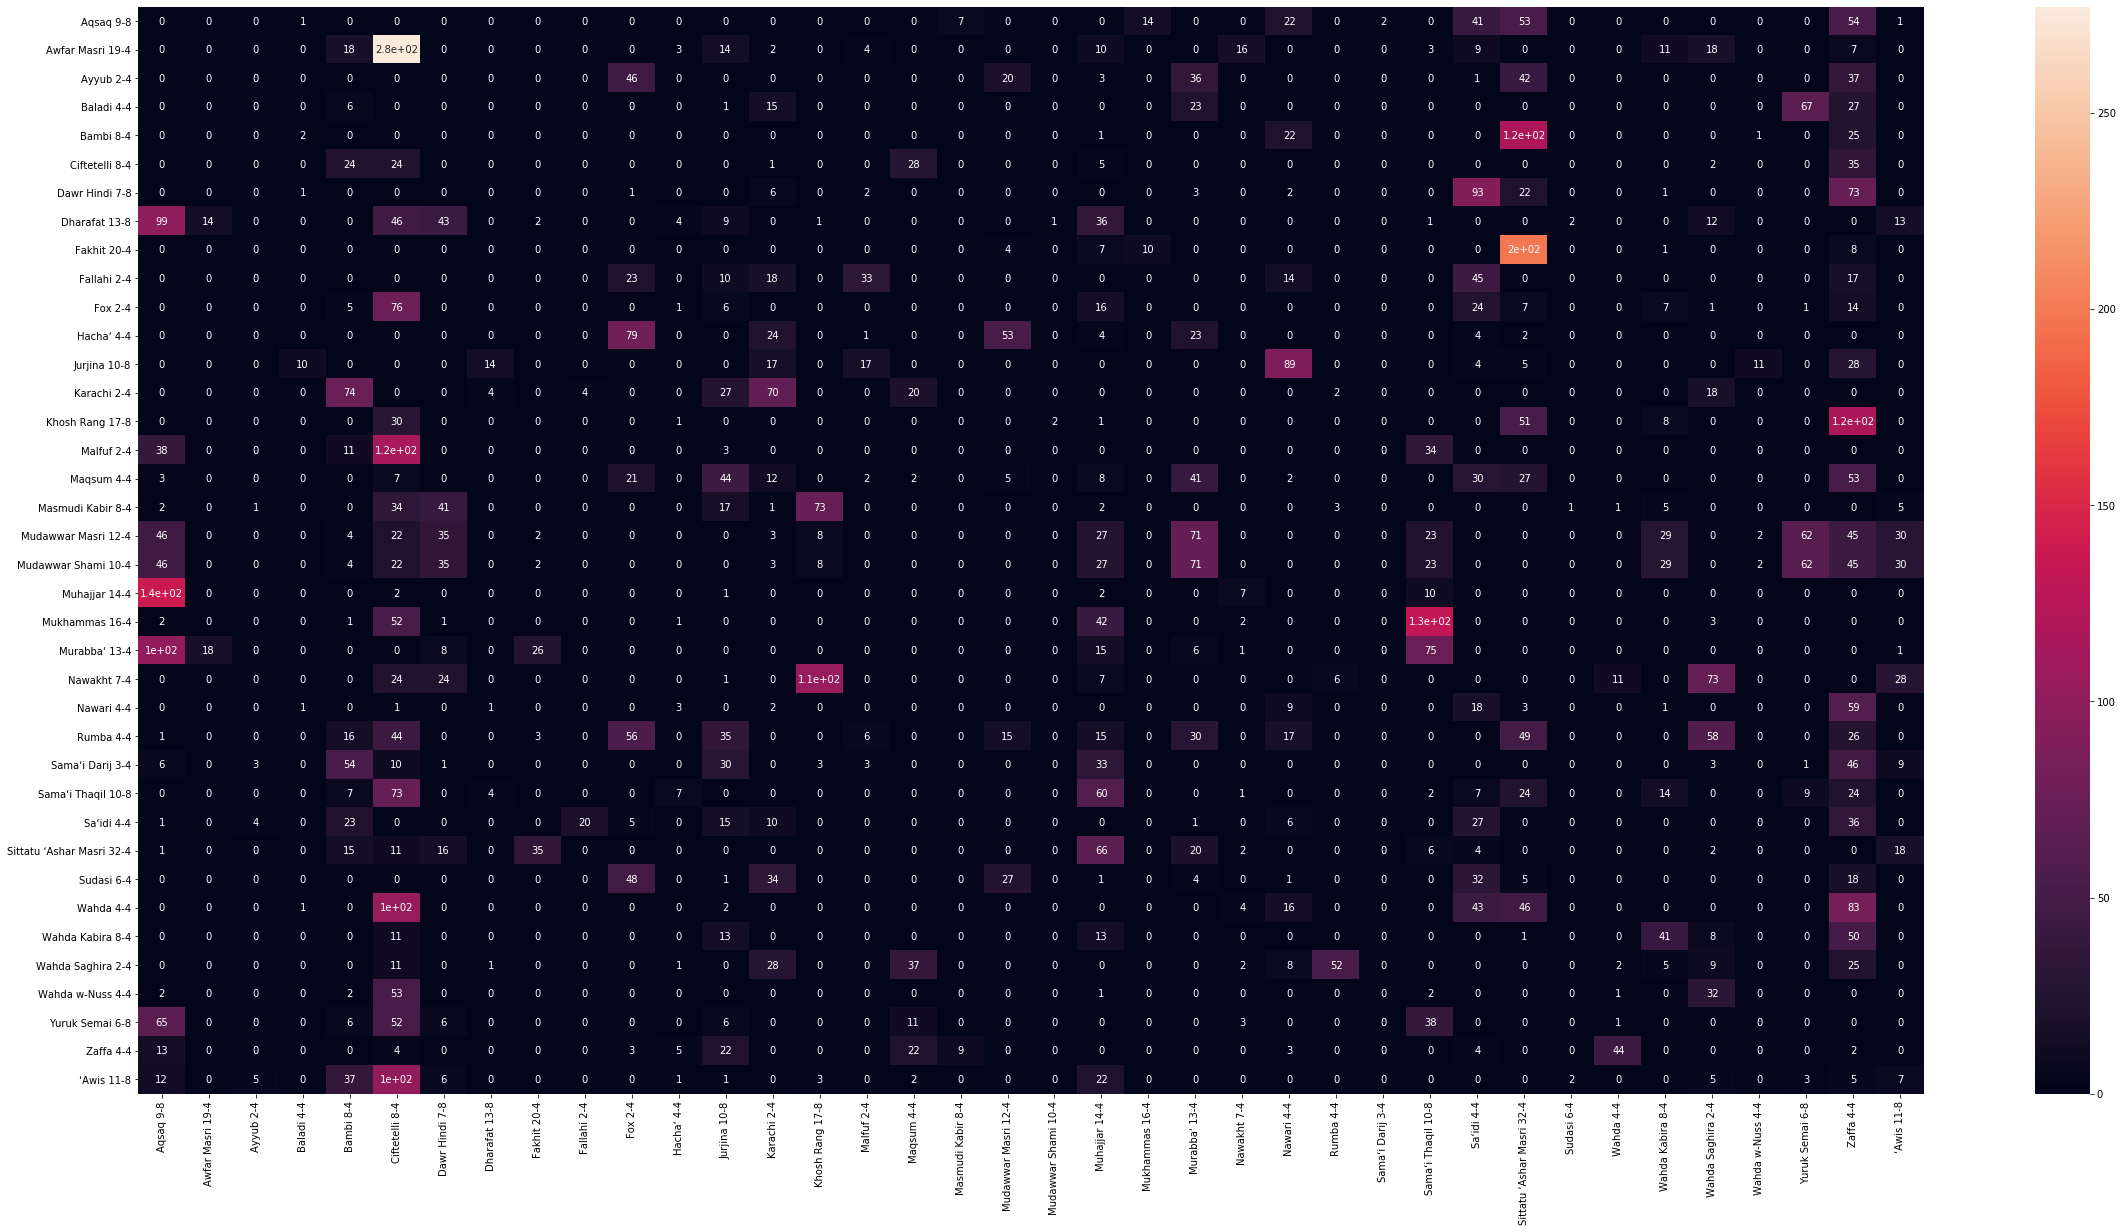

In [66]:
plt.figure(figsize=(40,20))
sns.heatmap(cf_matrix, annot=True, xticklabels=le.classes_, yticklabels=le.classes_)

In [15]:
!nvidia-smi

Sat Dec 14 21:47:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    50W / 250W |   6715MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

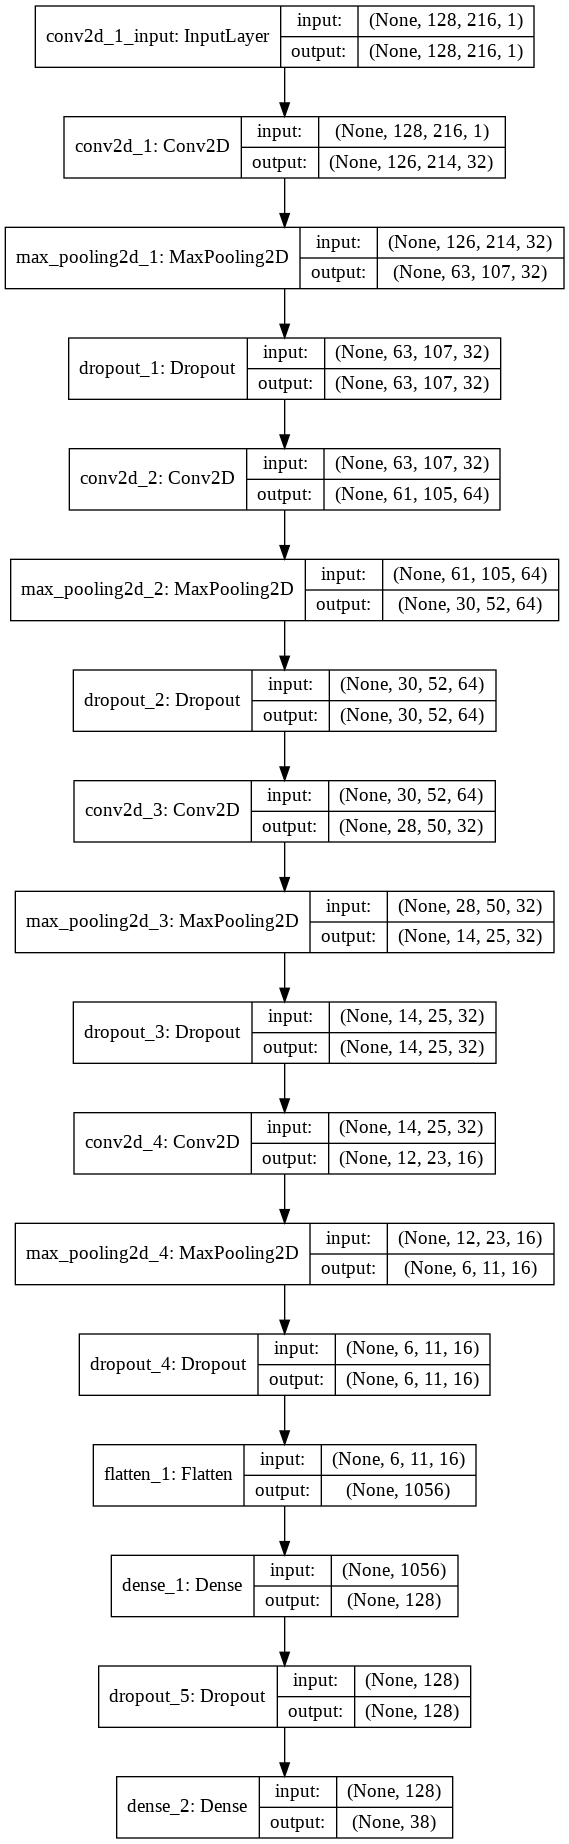

In [16]:
from keras.utils import plot_model

plot_model(model, show_shapes=True)

In [ ]:
def load_fitted_model(saving_path):

    saved_model_path = os.path.join(saving_path,'fitted_model.h5')

    assert os.path.exists(saved_model_path), 'fitted file does not exist in experiment folder'

    return keras.models.load_model(saved_model_path)

def make_prediction(X, saving_path):

    loaded_model = load_fitted_model(saving_path)
    predicted = loaded_model.predict_classes(X)

    return predicted

In [ ]:
import librosa

def load_file(audio_path):

    y, sr = librosa.load(audio_path)
    
    return y, sr

def get_percussion(y):
    
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    
    return y_percussive


def get_mel(y, sr):
    
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.amplitude_to_db(S)
    
    return log_S

def mel_slices_from_audio(y, sr, window_size_seconds=5):
    
    window_size = window_size_seconds *sr
#     len_seconds = y.shape[0] / sr
    samples_len = y.shape[0]
    n_windows, _ = divmod(samples_len, sr)

    rounded_samples_len =  (n_windows- window_size_seconds + 1) * sr

    mel_matrix = []

    for i in range(0, rounded_samples_len, sr):

        y_slice = y[i: i + window_size]
        y_percussion= get_percussion(y_slice)
        mel_slice = get_mel(y_percussion, sr)


        mel_matrix.append(mel_slice)

    return np.array(mel_matrix)




In [ ]:
malfuf_file= "/content/drive/My Drive/Colab Notebooks/Jasim/sample_audio/Eqaa/Malfuf88.wav"
malfuf_2_file= "/content/drive/My Drive/Colab Notebooks/Jasim/sample_audio/Eqaa/malfuf_2.mp3"
malfuf_3_file= "/content/drive/My Drive/Colab Notebooks/Jasim/sample_audio/Eqaa/from_training_Malfuf_amal_hayati.mp3"
maqsum_file= "/content/drive/My Drive/Colab Notebooks/Jasim/sample_audio/Eqaa/Maqsum135.wav"
rumba_file= "/content/drive/My Drive/Colab Notebooks/Jasim/sample_audio/Eqaa/rumb_from_training_darit_ayam.mp3"
saidi_training_file= "/content/drive/My Drive/Colab Notebooks/Jasim/sample_audio/Eqaa/training_saidi_habba_fouq.mp3"
saidi_test_file= "/content/drive/My Drive/Colab Notebooks/Jasim/sample_audio/Eqaa/test_saidi_3ala_hisb_widad.mp3"

In [ ]:
def jasam(audio_file):
    
    y, sr = load_file(audio_file)
    mel_matrix= mel_slices_from_audio(y, sr)
    mel_matrix_scaled= nstd_scaler.transform(mel_matrix)
    predicted_classes= make_prediction(np.expand_dims(mel_matrix_scaled, axis=-1), SAVING_PATH)

    classes_sorted = sorted(Counter(le.inverse_transform(predicted_classes)).items(), key=lambda x:-x[1])

    return classes_sorted

In [22]:
jasam(malfuf_file)

[('Sa‘idi 4-4', 10),
 ('Ciftetelli 8-4', 6),
 ('Hacha‘ 4-4', 3),
 ('Sama‘i Thaqil 10-8', 2)]

In [23]:
jasam(maqsum_file)

[('Ciftetelli 8-4', 20), ('Hacha‘ 4-4', 2), ('Sa‘idi 4-4', 2)]

In [24]:
jasam(malfuf_2_file)

[('Sa‘idi 4-4', 89),
 ('Zaffa 4-4', 9),
 ('Muhajjar 14-4', 7),
 ('Mudawwar Shami 10-4', 5)]

In [25]:
jasam(malfuf_3_file)

[('Bambi 8-4', 6),
 ('Ciftetelli 8-4', 2),
 ('Murabba‘ 13-4', 1),
 ('Aqsaq 9-8', 1)]

In [26]:
jasam(rumba_file)

[('Maqsum 4-4', 9),
 ('Rumba 4-4', 6),
 ('Wahda Kabira 8-4', 1),
 ('Ciftetelli 8-4', 1)]

In [27]:
print(jasam(saidi_training_file))
print(jasam(saidi_test_file))

[('Sa‘idi 4-4', 34)]
[('Sa‘idi 4-4', 46)]


In [ ]:
test_songs_df